In [ ]:
# split data so test is 50/50 (around 20 for each)
# 128x128x3 -> 240 samples
# fit model -> not great
# try transfer learning -> then 'fine tune' our model
    # VGG19 (19 layers)
    # first layers capture simple features, the next capture a shape, and more abstract as we go
    # freeze weights until the final layer -> add/modify the last few layers (try different number of nodes)
    
# try: increasing resolution (not helpful so far)
    # number of epoch
    # 16 nodes
    # Alex, Inception, LeNet, (VGG19)

In [5]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers, models, optimizers, callbacks

import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
#from utils import combine_images
from PIL import Image, ImageOps

from keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import shutil
import os

import argparse

from keras.layers import Input, Conv2D, BatchNormalization, Activation, Flatten, Dense, Dropout
from keras.layers import ZeroPadding2D, MaxPooling2D
from keras.models import Model
from keras import regularizers
import scipy.ndimage
from keras import applications
from keras.models import Sequential
import time
import keras

# Data processing

In [6]:
# set directory
#root_dir = os.path.abspath('.')
#data_dir = os.path.join(root_dir, 'Diabetes')
data_dir = os.path
print(data_dir)

/Users/mitchmaegaard/Diabetes


In [7]:
# Read file (skip the first two rows)
df = pd.read_csv(os.path.join(data_dir, 'translateddata.csv'), skiprows = 2)
df = df.dropna(subset = ["status"]) # 状态 -- col 'E'
df.head()

,ID,bed_no,code,glycated_hemoglobin_value,status,hemoglobin_value,age,gender,height,weight,...,Do you have a heart?,Do you have asthma or feel not angry enough?,Do you have chest tightness or chest pain?,Do you have a headache?,Do you have high blood pressure?,Are you dry skin?,Do you have a family member with diabetes?,Is there a diabetic retinopathy?,Is there a diabetic foot?,Unnamed: 57
0,62503,02250237,201-02250237,5.7,前期糖尿病,143.0,62.0,0.0,158.0,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,无
1,62504,16260230,201-16260230,5.1,正常,153.0,31.0,1.0,168.0,140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,无
2,62508,16260231,201-16260231,5.7,前期糖尿病,130.0,46.0,0.0,155.0,108.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,无
3,62509,16260232,201-16260232,5.7,前期糖尿病,170.0,38.0,1.0,181.0,360.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,无
4,62510,16260233,201-16260233,5.1,正常,123.0,64.0,1.0,166.0,135.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,无


In [8]:
# Select the healty patient ID according to the status column
id_healthy = df["ID"][df["status"] == "正常"] # df['A'][df['E']]
id_diabete = df["ID"][df["status"] != "正常"] # mutliple levels of diabetes -- just check one for now

# Check if it contains all data
print("Dataframe has", df.shape[0], "patients")
print("Number of healthy patitents,", len(id_healthy))
print("Number of diabete patitents,", len(id_diabete))

Dataframe has 147 patients
Number of healthy patitents, 36
Number of diabete patitents, 111


In [9]:
source_dir = os.path.join(data_dir, 'Newest')
number_files_source = len(os.listdir(source_dir))
healthy_dir = os.path.join(data_dir, 'Healthy')
diabete_dir = os.path.join(data_dir, 'Diabete')  
       
number_files_healthy = len(os.listdir(healthy_dir))
number_files_diabete = len(os.listdir(diabete_dir))

# Count files to make sure we have all the data
print("No. pics in source folder: ", number_files_source) # should be one extra in source
print("No. pics in healthy folder:", number_files_healthy)
print("No. pics in diabete folder:", number_files_diabete)

No. pics in source folder:  694
No. pics in healthy folder: 473
No. pics in diabete folder: 218


# Read image to array
Normalize picture size and add labels.

In [10]:
# Assign new pixel resolution
w = 128
h = 128
image_size = (w,h)

# Set up healthy images
m = len(os.listdir(healthy_dir))
image_healthy = np.zeros((m,w,h,3))
i = 0 
for pic in os.listdir(healthy_dir):
    img = Image.open(healthy_dir + "/" + pic).convert('RGB') # dealing with some 4-color channels (transparency)
    img = ImageOps.fit(img, image_size, Image.ANTIALIAS)
    img = np.array(img)
    image_healthy[i,:,:,:] = img
    i = i+1

# Label healthy to be 0
y_healthy = np.zeros((len(image_healthy),1))


# Set up diabete images
n = len(os.listdir(diabete_dir))
image_diabete = np.zeros((n,w,h,3))
j = 0
for pic in os.listdir(diabete_dir):
    img = Image.open(diabete_dir + "/" + pic).convert('RGB')
    img = ImageOps.fit(img, image_size, Image.ANTIALIAS)
    img = np.array(img)
    image_diabete[j,:,:,:] = img
    j = j+1
    
# Label diabete to be 1
y_diabete = np.ones((len(image_diabete),1))

# Check images
print(image_healthy.shape, image_diabete.shape)

(473, 128, 128, 3) (218, 128, 128, 3)


In [11]:
# Save the results
np.save("image_healthy",image_healthy)
np.save("image_diabete",image_diabete)
np.save("y_healthy",y_healthy)
np.save("y_diabete",y_diabete)

# Load data and convert to tensor

In [21]:
# Load
image_diabete = np.load("image_diabete.npy")
image_healthy = np.load("image_healthy.npy")
y_diabete = np.load("y_diabete.npy")
y_healthy = np.load("y_healthy.npy")

np.random.seed(1228)
# Prepare 40 images for test dataset (20 each)
size_test = 20
n_healthy = image_healthy.shape[0] # set parameter for number in each set
n_diabete = image_diabete.shape[0]
index_healthy = np.random.choice(n_healthy,size_test,replace=False) # get random set from healthy & diabete
index_diabete = np.random.choice(n_diabete,size_test,replace=False)

In [22]:
# Create test set
x_test = np.vstack((image_healthy[index_healthy,:,:,:],image_diabete[index_diabete,:,:,:]))
y_test = np.vstack((y_healthy[index_healthy,:],y_diabete[index_diabete,:]))

# Create training set
x_train = np.vstack((np.delete(image_healthy,index_healthy,0), np.delete(image_diabete,index_diabete,0)))
y_train = np.vstack((np.delete(y_healthy,index_healthy,0),np.delete(y_diabete,index_diabete,0)))

In [23]:
# Number in each set
n_train = x_train.shape[0]
n_test = x_test.shape[0]

# Shuffle by row
shuffle = np.random.permutation(n_train)

x_train = np.take(x_train,shuffle,axis=0,out=x_train)
y_train = np.take(y_train,shuffle,axis=0,out=y_train)

In [24]:
# Normalize the images:
    # Use 32-bit precision when training NN
    # 255 is max value of a byte -- ensures that the input features are scaled between 0.0 and 1.0
        # learning rate works well and cost takes on reasonable values

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convert class vectors to binary class matrices
    # Not necessary for detecting diabete/healthy, but useful when we have multi-class classification
y_train = to_categorical(y_train.astype('float32')) # num_classes set to NULL to auto-detect from input
y_test = to_categorical(y_test.astype('float32'))

print("Training data: ", (x_train.shape, y_train.shape))
print("Testing data:  ", (x_test.shape, y_test.shape))

Training data:  ((651, 128, 128, 3), (651, 2))
Testing data:   ((40, 128, 128, 3), (40, 2))


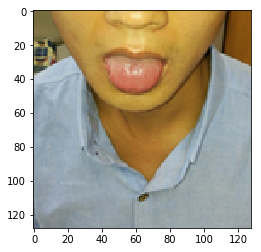

In [25]:
plt.imshow(x_train[1,:,:,:])
plt.show()

In [17]:
# Split data into train and validation
#split_size = int(x_train.shape[0]*0.7)

#x_train, x_val = x_train[:split_size], x_train[split_size:]
#y_train, y_val = y_train[:split_size], y_train[split_size:]

# Data augmentation
Skip for primary run, implement later

In [26]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

#Fit the generator to the training data
datagen.fit(x_train)

#Generate augmented training set 
copy = 2
x_batch = np.zeros((n_train * copy, x_train.shape[1],x_train.shape[2], x_train.shape[3]))
y_batch = np.zeros((n_train * copy, 1))

for i in range(copy):
    x_temp,y_temp = datagen.flow(x_train, y_train, batch_size = n_train).next()
    x_batch[i*n_train:(i+1)*n_train,:,:,:] = x_temp
#     y_batch[i*n_train:(i+1)*n_train,1] = y_temp
    i = i+1

# Transfer learning model

In [33]:
input_shape = x_train.shape[1:4]

#load base_model
base_model = applications.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape= input_shape)

# print(base_model.summary())

top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(16, activation='relu'))
top_model.add(Dropout(0.2))
top_model.add(Dense(2, activation='sigmoid'))

transfer_model = Model(inputs= base_model.input, outputs= top_model(base_model.output))


for layer in transfer_model.layers[:19]:
    layer.trainable = False

In [34]:
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [35]:
# width,height = X_batch.shape[1:3]
#lam is the parameter for l2 regularization 
# DiabetesModel = CnnModel((width,height,3),lam = 0.1,dropout = 1)
DiabetesModel = transfer_model
# print(width)
# print(DiabetesModel.summary())


class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()



#Compile model
DiabetesModel.compile(optimizer = "Adam",loss = "binary_crossentropy", metrics = ["accuracy"])

In [36]:
#Fit the model
history = DiabetesModel.fit(x = x_train, y = y_train,
                            callbacks = [time_callback],
                            validation_split=0.2,
                            epochs = 50,
                            batch_size = 20)
times = time_callback.times

Train on 520 samples, validate on 131 samples
Epoch 1/50
520/520 [==============================] - 2040s 4s/step - loss: 0.4738 - acc: 0.7038 - val_loss: 0.3106 - val_acc: 0.8740
Epoch 2/50
520/520 [==============================] - 1840s 4s/step - loss: 0.3024 - acc: 0.8298 - val_loss: 0.2745 - val_acc: 0.7977
Epoch 3/50
520/520 [==============================] - 8378s 16s/step - loss: 0.2688 - acc: 0.8433 - val_loss: 0.2491 - val_acc: 0.8130
Epoch 4/50
520/520 [==============================] - 1739s 3s/step - loss: 0.2436 - acc: 0.8490 - val_loss: 0.2224 - val_acc: 0.8168
Epoch 5/50
520/520 [==============================] - 1725s 3s/step - loss: 0.2126 - acc: 0.8567 - val_loss: 0.2075 - val_acc: 0.8092
Epoch 6/50
520/520 [==============================] - 1722s 3s/step - loss: 0.1890 - acc: 0.8548 - val_loss: 0.2098 - val_acc: 0.8168
Epoch 7/50
520/520 [==============================] - 1730s 3s/step - loss: 0.1687 - acc: 0.9163 - val_loss: 0.1779 - val_acc: 0.9351
Epoch 8/50
520/

KeyboardInterrupt: 

In [37]:
# Plot loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross_validation'], loc='upper left')
plt.show()

# Plot accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross_validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

<Figure size 576x432 with 0 Axes>

# Test model

In [ ]:
#Predictjl accuracy
preds = DiabetesModel.evaluate(x = x_test, y = y_test)
print ("Test Accuracy = " + str(preds[1]))

# CapsNet Implementation

In [84]:
K.set_image_data_format('channels_last')

In [75]:
def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model

In [76]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [77]:
def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(args.save_dir + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=args.save_dir + '/tensorboard-logs',
                               batch_size=args.batch_size, histogram_freq=int(args.debug))
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],
                  metrics={'capsnet': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, args.batch_size, args.shift_fraction),
                        steps_per_epoch=int(y_train.shape[0] / args.batch_size),
                        epochs=args.epochs,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, tb, checkpoint, lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

    from utils import plot_log
    plot_log(args.save_dir + '/log.csv', show=True)

    return model

In [38]:
# helper function
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[2:]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[0, :, :]
    return image

# Capsule Layers
Implementing layers that our CapsNet will be utilizing. Cloned from GitHub, but not working with directory for some reason.

In [79]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config

In [80]:
class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config

In [81]:
def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [82]:
class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, dim=1)

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [83]:
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

# Capsule network model
Too computationally expensive right now, try again when we have access to GPU

In [103]:
# Define model
model, eval_model, manipulate_model = CapsNet(input_shape=x_train.shape[1:],
                                              n_class=len(np.unique(np.argmax(y_train, 1))),
                                              routings=3)

In [104]:
#trained_model = train(model=model, data=((x_train, y_train), (x_test, y_test)), args=args)

model.compile(optimizer=optimizers.Adam(lr=0.001),
             loss=[margin_loss, 'mse'],
             loss_weights=[1., 0.392],
             metrics={'capsnet': 'accuracy'})

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 120, 120, 256 62464       input_20[0][0]                   
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 56, 56, 256)  5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 100352, 8)    0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

In [105]:
def train_generator(x, y, batch_size, shift_fraction=0.):
    train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                        height_shift_range=shift_fraction)
    generator = train_datagen.flow(x, y, batch_size=batch_size)
    while 1:
        x_batch, y_batch = generator.next()
        yield ([x_batch, y_batch], [y_batch, x_batch])
        
# setting hyperparameters
batch_size = 20
shift_fraction = 0.2
epochs = 15
        
# Training with data augmentation
trained_model = model.fit_generator(generator=train_generator(x_train, y_train, batch_size, shift_fraction),
                                    steps_per_epoch=int(y_train.shape[0] / batch_size),
                                    epochs=epochs,
                                    validation_data=[[x_test, y_test], [y_test, x_test]])

Epoch 1/15
11/11 [==============================] - 8513s 774s/step - loss: 0.4652 - capsnet_loss: 0.4415 - decoder_loss: 0.0603 - capsnet_acc: 0.6500 - val_loss: 0.4264 - val_capsnet_loss: 0.4050 - val_decoder_loss: 0.0547 - val_capsnet_acc: 0.5250
Epoch 2/15
 2/11 [====>.........................] - ETA: 29:29:09 - loss: 0.4264 - capsnet_loss: 0.4050 - decoder_loss: 0.0545 - capsnet_acc: 0.3500 

KeyboardInterrupt: 

# Test model

In [6]:
def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()